### Training

In [10]:
from Setting import databaseSetting
from vanna.remote import VannaDefault
vn = VannaDefault(model='everpixanalysis', api_key='4f98f48a39214bca913dc4560f440f07')
# vn.connect_to_...() # Connect to your database here
vn.connect_to_postgres(
    host=databaseSetting.host,
    dbname='postgres',
    user=databaseSetting.username,
    port=databaseSetting.port,
    password=databaseSetting.password
)



In [15]:
# The information schema query may need some tweaking depending on your database. This is a good starting point.
# df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS WHERE table_schema = 'public'")
# df_information_schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,postgres,public,kpis_subscriptions_sold,Apple Monthly,4,None,YES,double precision,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,postgres,public,android_device_distribution_past_2_weeks,Count,2,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,postgres,public,user_cohorts_free_users_retention_excl_uploaders,Last 30 Days,4,None,YES,double precision,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,postgres,public,user_cohorts_free_users_retention_uploaders_tried,Last 24 Hours,2,None,YES,double precision,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,postgres,public,user_cohorts_free_users_retention_uploaders_tried,Last 7 Days,3,None,YES,double precision,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,postgres,public,kpis_user_subscription_rate,Date,1,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
517,postgres,public,user_cohorts_users_unified_retention_7_days,Week,1,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
518,postgres,public,system_users_first_time_visitors_web_invites_r...,Day,1,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
519,postgres,public,system_aws_detailed_spending_since_2012_10_01,Product,1,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [16]:
# # This will break up the information schema into bite-sized chunks that can be referenced by the LLM
# plan = vn.get_training_plan_generic(df_information_schema)
# plan

Train on Information Schema: postgres.public kpis_subscriptions_sold
Train on Information Schema: postgres.public android_device_distribution_past_2_weeks
Train on Information Schema: postgres.public user_cohorts_free_users_retention_excl_uploaders
Train on Information Schema: postgres.public user_cohorts_free_users_retention_uploaders_tried
Train on Information Schema: postgres.public user_cohorts_free_users_tried_everpix_sharing
Train on Information Schema: postgres.public user_cohorts_signup_origins
Train on Information Schema: postgres.public user_cohorts_subscribed_users_avg_photos
Train on Information Schema: postgres.public user_cohorts_subscribed_users_connected_services
Train on Information Schema: postgres.public user_cohorts_subscribed_users_modifying_photos
Train on Information Schema: postgres.public user_cohorts_subscribed_users_retention_excl_uploaders
Train on Information Schema: postgres.public user_cohorts_subscribed_users_retention_uploaders_tried
Train on Informatio

In [18]:
# If you like the plan, then uncomment this and run it to train
# vn.train(plan=plan)

In [2]:
import psycopg2
from Setting import databaseSetting

def get_table_ddl(cursor, table_name):
    cursor.execute(f"SELECT table_name, column_name, data_type, is_nullable, character_maximum_length FROM information_schema.columns WHERE table_name = '{table_name}' ORDER BY ordinal_position;")
    columns = cursor.fetchall()
    ddl = f"CREATE TABLE {table_name} ("
    column_definitions = []
    for column in columns:
        column_def = f"{column[1]} {column[2]}"
        if column[4]:
            column_def += f"({column[4]})"
        if column[3] == "NO":
            column_def += " NOT NULL"
        column_definitions.append(column_def)
    ddl += ",".join(column_definitions)
    ddl += ");"
    return ddl

def get_all_tables_ddl(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';")
    tables = cursor.fetchall()
    ddls = {}
    for table in tables:
        table_name = table[0]
        ddls[table_name] = get_table_ddl(cursor, table_name)
    return ddls

connection = psycopg2.connect(
        dbname=databaseSetting.database,
        user=databaseSetting.username,
        password=databaseSetting.password,
        host=databaseSetting.host,
        port=databaseSetting.port
    )
    
ddls = get_all_tables_ddl(connection)
# for table_name, ddl in ddls.items():
#     print(f"DDL for {table_name}:\n{ddl}\n")

connection.close()


In [3]:
ddl_list=list(ddls.values())
ddl_list

['CREATE TABLE aaaaa (index bigint,a bigint,b bigint);',
 'CREATE TABLE android_device_distribution_past_2_weeks (device text,count bigint);',
 'CREATE TABLE android_device_distribution (device text,count bigint);',
 'CREATE TABLE android_version_distribution_past_2_weeks (version double precision,count bigint);',
 'CREATE TABLE android_version_distribution (version double precision,count bigint);',
 'CREATE TABLE android_app_version_distribution_past_2_weeks (device text,count bigint);',
 'CREATE TABLE appstore_downloads_by_week (week text,installs double precision,updates double precision);',
 'CREATE TABLE appstore_installs_per_version (version text,total double precision);',
 'CREATE TABLE appstore_users_allowing_push_notifications (week text,ratio double precision);',
 'CREATE TABLE appstore_ios_authtokens_created (week text,count bigint);',
 'CREATE TABLE bonus_popularity (bonus text,count bigint);',
 'CREATE TABLE bonus_free_users_granted_months (percentile double precision,mont

In [4]:
for ddl in ddl_list:
    vn.train(ddl=ddl)

Adding ddl: CREATE TABLE aaaaa (index bigint,a bigint,b bigint);
Adding ddl: CREATE TABLE android_device_distribution_past_2_weeks (device text,count bigint);
Adding ddl: CREATE TABLE android_device_distribution (device text,count bigint);
Adding ddl: CREATE TABLE android_version_distribution_past_2_weeks (version double precision,count bigint);
Adding ddl: CREATE TABLE android_version_distribution (version double precision,count bigint);
Adding ddl: CREATE TABLE android_app_version_distribution_past_2_weeks (device text,count bigint);
Adding ddl: CREATE TABLE appstore_downloads_by_week (week text,installs double precision,updates double precision);
Adding ddl: CREATE TABLE appstore_installs_per_version (version text,total double precision);
Adding ddl: CREATE TABLE appstore_users_allowing_push_notifications (week text,ratio double precision);
Adding ddl: CREATE TABLE appstore_ios_authtokens_created (week text,count bigint);
Adding ddl: CREATE TABLE bonus_popularity (bonus text,count b

In [11]:
from vanna.flask import VannaFlaskApp
VannaFlaskApp(vn).run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on


### chromadb

In [1]:
# The import statement will vary depending on your LLM and vector database. This is an example for OpenAI + ChromaDB

from vanna.openai.openai_chat import OpenAI_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)


### draft

SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE [Artist]\n(\n    [ArtistId] INTEGER  NOT NULL,\n    [Name] NVARCHAR(120),\n    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])\n)\n\nCREATE TABLE [Album]\n(\n    [AlbumId] INTEGER  NOT NULL,\n    [Title] NVARCHAR(160)  NOT NULL,\n    [ArtistId] INTEGER  NOT NULL,\n    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),\n    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)\n\nCREATE INDEX [IFK_AlbumArtistId] ON [Album] ([ArtistId])\n\nCREATE TABLE [Track]\n(\n    [TrackId] INTEGER  NOT NULL,\n    [Name] NVARCHAR(200)  NOT NULL,\n    [AlbumId] INTEGER,\n    [MediaTypeId] INTEGER  NOT NULL,\n    [GenreId] INTEGER,\n    [Composer] NVARCHAR(220),\n    [Milliseconds] INT

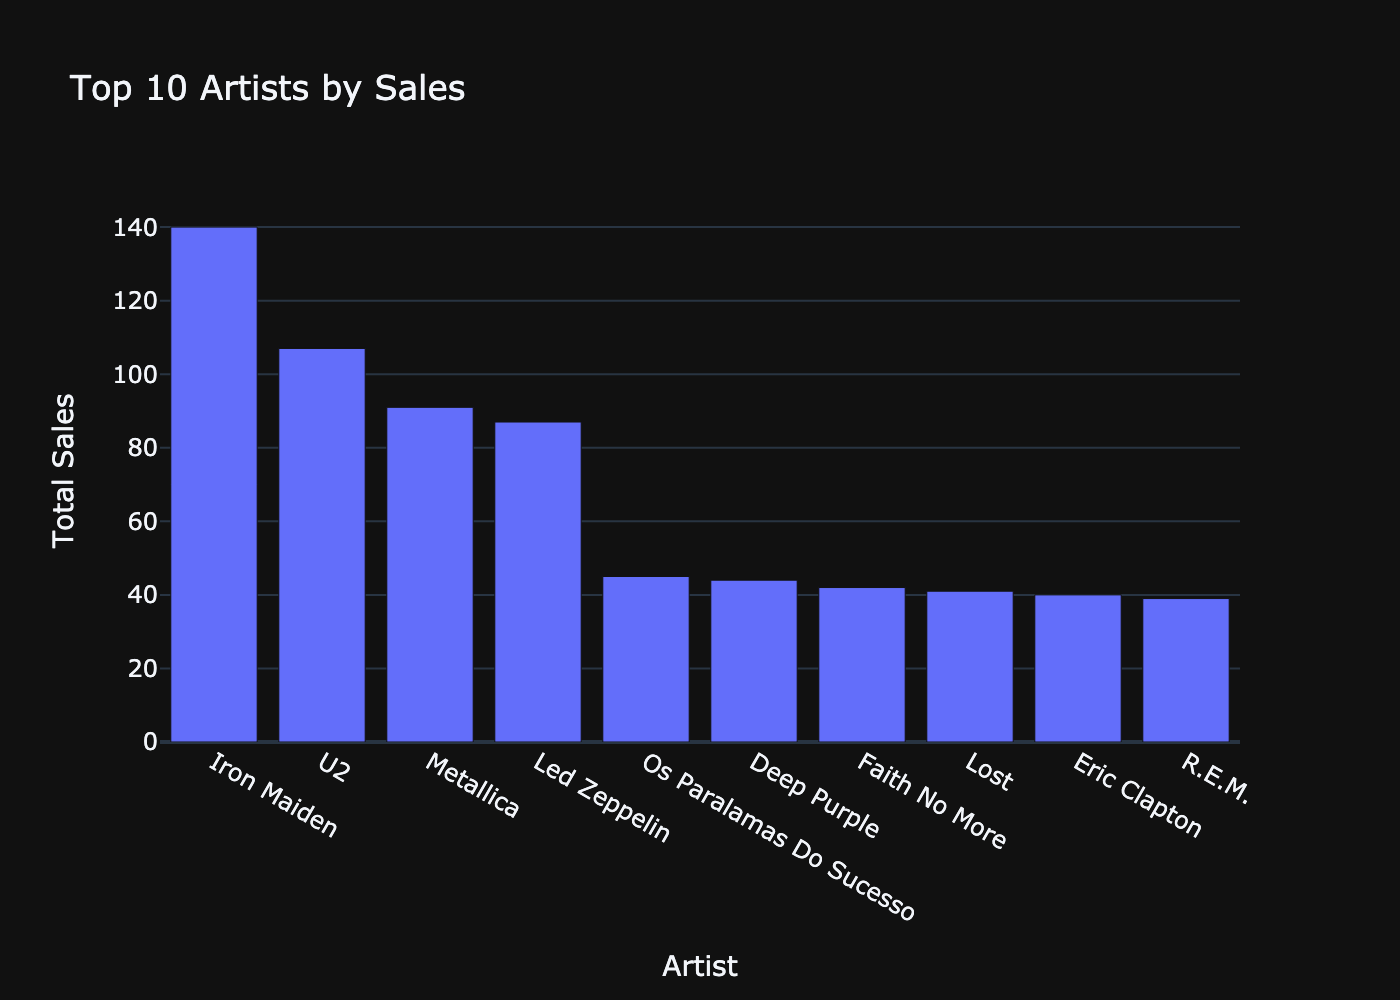

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on


In [2]:
from vanna.remote import VannaDefault
vn = VannaDefault(model='chinook', api_key='4f98f48a39214bca913dc4560f440f07')
vn.connect_to_sqlite('https://vanna.ai/Chinook.sqlite')
vn.ask('What are the top 10 artists by sales?')

from vanna.flask import VannaFlaskApp
VannaFlaskApp(vn).run()

In [5]:
from Setting import databaseSetting
from vanna.remote import VannaDefault
vn = VannaDefault(model='everpix', api_key='4f98f48a39214bca913dc4560f440f07')
# vn.connect_to_...() # Connect to your database here
vn.connect_to_postgres(
    host=databaseSetting.host,
    dbname='testdb',
    user=databaseSetting.username,
    port=databaseSetting.port,
    password=databaseSetting.password
)



In [6]:
# The information schema query may need some tweaking depending on your database. This is a good starting point.
df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA.COLUMNS")
df_information_schema

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,testdb,pg_catalog,pg_type,typsubscript,13,None,NO,regproc,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,testdb,public,Sendgrid_Invites,Unique Clicks,5,None,YES,double precision,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,testdb,pg_catalog,pg_class,relpersistence,16,None,NO,"""char""",NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,testdb,information_schema,element_types,collection_type_identifier,5,None,YES,name,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,NO
4,testdb,information_schema,table_privileges,is_grantable,7,None,YES,character varying,3.0,1.200000e+01,...,NO,None,None,None,None,None,NO,NEVER,None,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521,testdb,pg_catalog,pg_stat_replication,application_name,4,None,YES,text,NaN,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,NO
2522,testdb,information_schema,sql_implementation_info,character_value,4,None,YES,character varying,NaN,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2523,testdb,pg_catalog,pg_subscription,subskiplsn,3,None,NO,pg_lsn,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2524,testdb,information_schema,attributes,ordinal_position,5,None,YES,integer,NaN,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,NO


In [7]:
# This will break up the information schema into bite-sized chunks that can be referenced by the LLM
plan = vn.get_training_plan_generic(df_information_schema)
plan

Train on Information Schema: testdb.pg_catalog pg_type
Train on Information Schema: testdb.pg_catalog pg_class
Train on Information Schema: testdb.pg_catalog pg_stat_ssl
Train on Information Schema: testdb.pg_catalog pg_index
Train on Information Schema: testdb.pg_catalog pg_attribute
Train on Information Schema: testdb.pg_catalog pg_stat_progress_cluster
Train on Information Schema: testdb.pg_catalog pg_shseclabel
Train on Information Schema: testdb.pg_catalog pg_indexes
Train on Information Schema: testdb.pg_catalog pg_database
Train on Information Schema: testdb.pg_catalog pg_amproc
Train on Information Schema: testdb.pg_catalog pg_stat_progress_vacuum
Train on Information Schema: testdb.pg_catalog pg_stat_database
Train on Information Schema: testdb.pg_catalog pg_default_acl
Train on Information Schema: testdb.pg_catalog pg_stat_user_tables
Train on Information Schema: testdb.pg_catalog pg_largeobject
Train on Information Schema: testdb.pg_catalog pg_statio_sys_tables
Train on Info

In [8]:
# If you like the plan, then uncomment this and run it to train
vn.train(plan=plan)

In [ ]:
# The following are methods for adding training data. Make sure you modify the examples to match your database.

# DDL statements are powerful because they specify table names, colume names, types, and potentially relationships
vn.train(ddl="""
    CREATE TABLE IF NOT EXISTS my-table (
        id INT PRIMARY KEY,
        name VARCHAR(100),
        age INT
    )
""")

# Sometimes you may want to add documentation about your business terminology or definitions.
vn.train(documentation="Our business defines OTIF score as the percentage of orders that are delivered on time and in full")

# You can also add SQL queries to your training data. This is useful if you have some queries already laying around. You can just copy and paste those from your editor to begin generating new SQL.
vn.train(sql="SELECT * FROM my-table WHERE name = 'John Doe'")

In [40]:
from vanna.flask import VannaFlaskApp
VannaFlaskApp(vn).run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on
None
